This essentially enables you to download the dataset from MedMNIST 

In [ ]:
import medmnist
from medmnist import DermaMNIST #REPLACE
import numpy as np

# Choose the image size (28 for classic, or 64/128/224 for MedMNIST+)
IMG_SIZE = 28  

# Download DermMNIST (train/val/test) automatically
train_dataset = DermaMNIST(split="train", download=True, size=IMG_SIZE) #REPLACE
val_dataset   = DermaMNIST(split="val", download=True, size=IMG_SIZE) #REPLACE
test_dataset  = DermaMNIST(split="test", download=True, size=IMG_SIZE) #REPLACE

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

# Each dataset item is a tuple (PIL.Image, label)
img, label = train_dataset[0]

# Convert PIL image → NumPy array
img_array = np.array(img)

print("Sample image shape:", img_array.shape, "Label:", label)


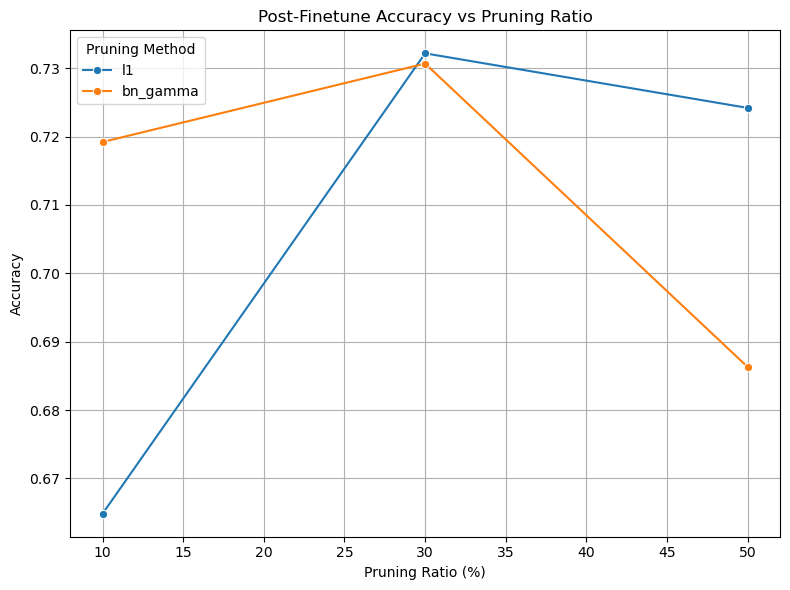

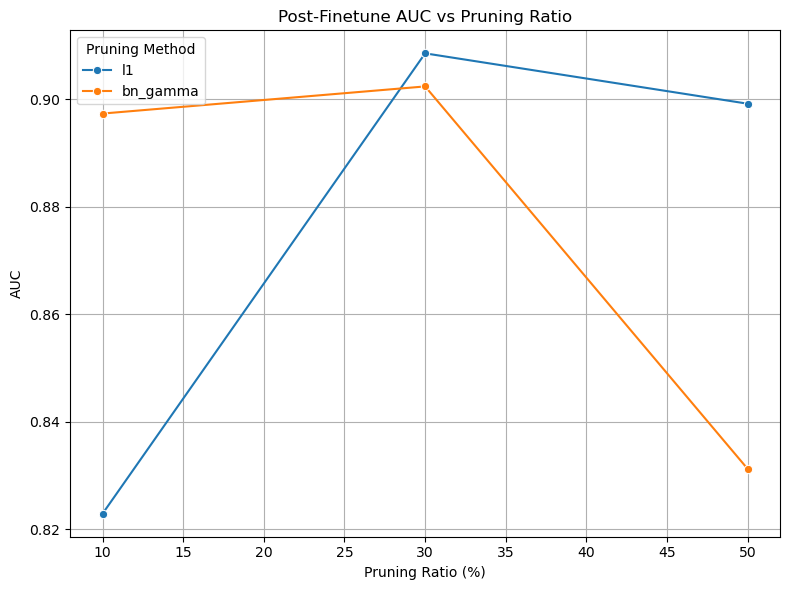

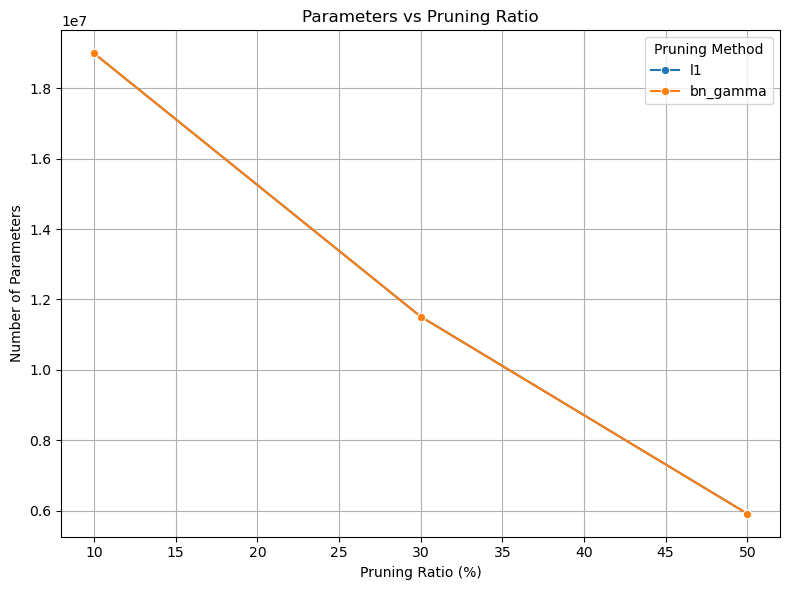

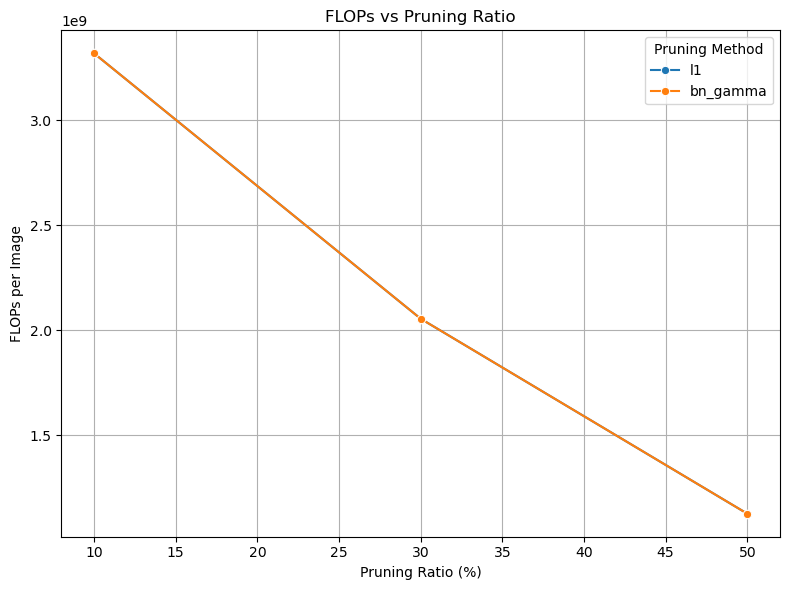

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Load CSV
# ---------------------------
csv_path = "/Users/arihangupta/Downloads/dermamnist_surgery_pruning_metrics.csv"  # update with your path
df = pd.read_csv(csv_path)

# ---------------------------
# Preprocess
# ---------------------------
# Convert Ratio to percentage for plotting
df['RatioPercent'] = df['Ratio'] * 100

# ---------------------------
# Plot Accuracy vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")], 
    x='RatioPercent', y='Acc', hue='Variant', marker='o'
)
plt.title("Post-Finetune Accuracy vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot AUC vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")], 
    x='RatioPercent', y='AUC', hue='Variant', marker='o'
)
plt.title("Post-Finetune AUC vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("AUC")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Params vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")],
    x='RatioPercent', y='Params', hue='Variant', marker='o'
)
plt.title("Parameters vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Number of Parameters")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot FLOPs vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")],
    x='RatioPercent', y='FLOPs_per_image', hue='Variant', marker='o'
)
plt.title("FLOPs vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("FLOPs per Image")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()


Block-by-Block pruning

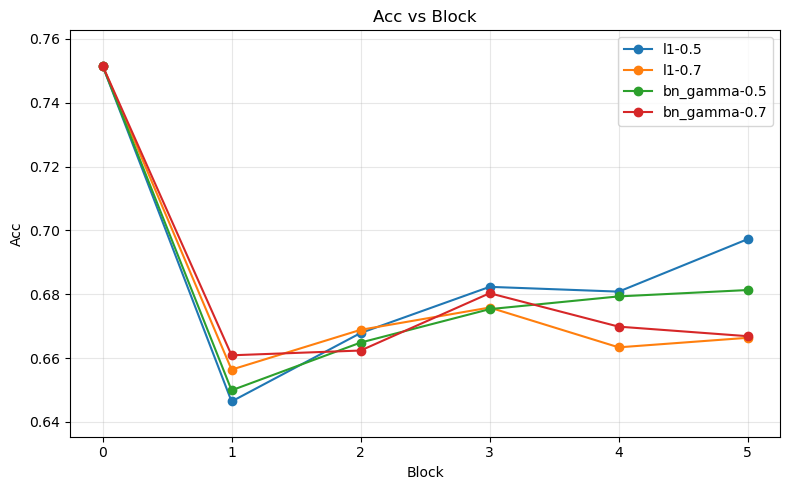

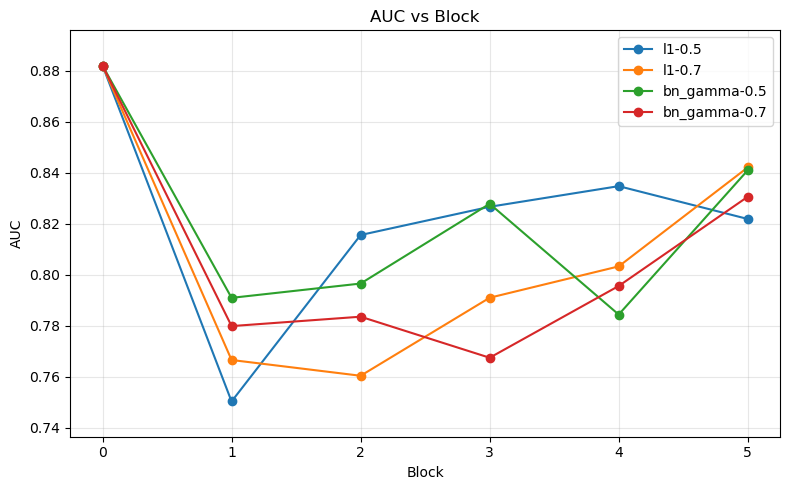

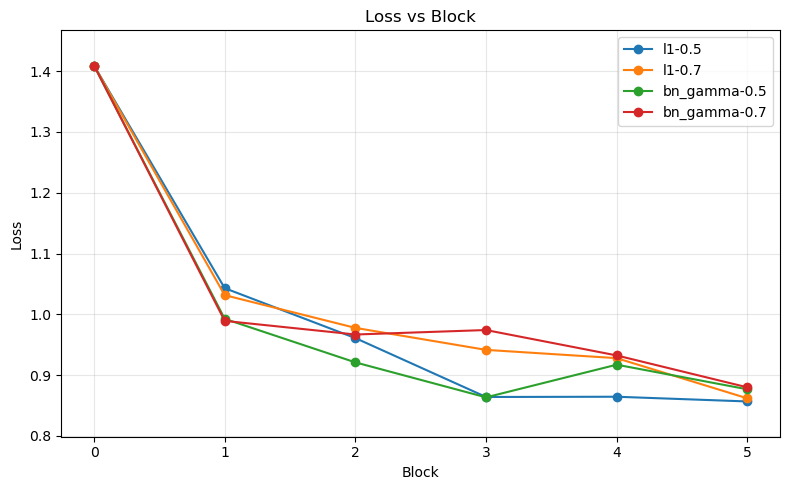

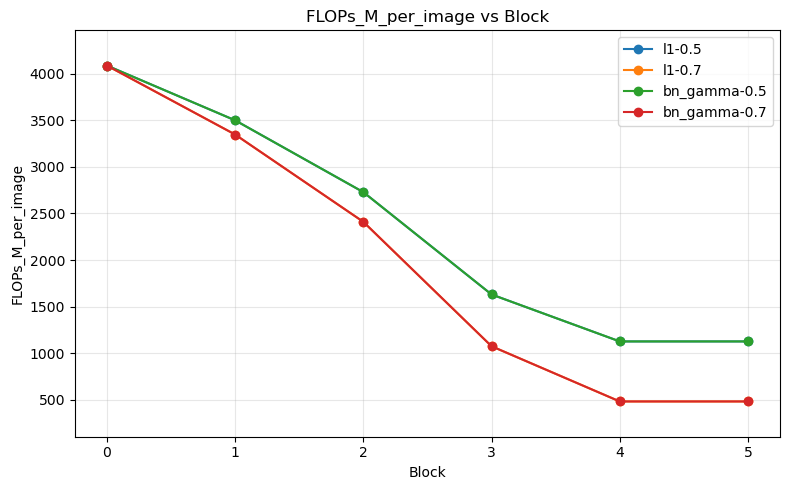

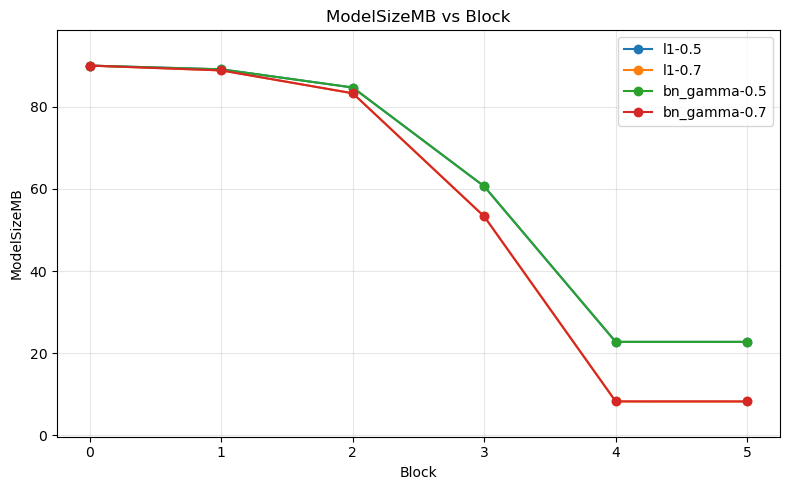

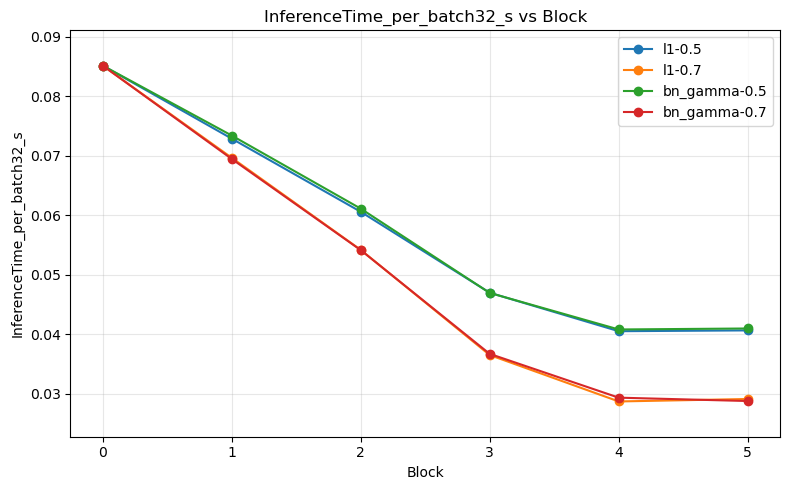

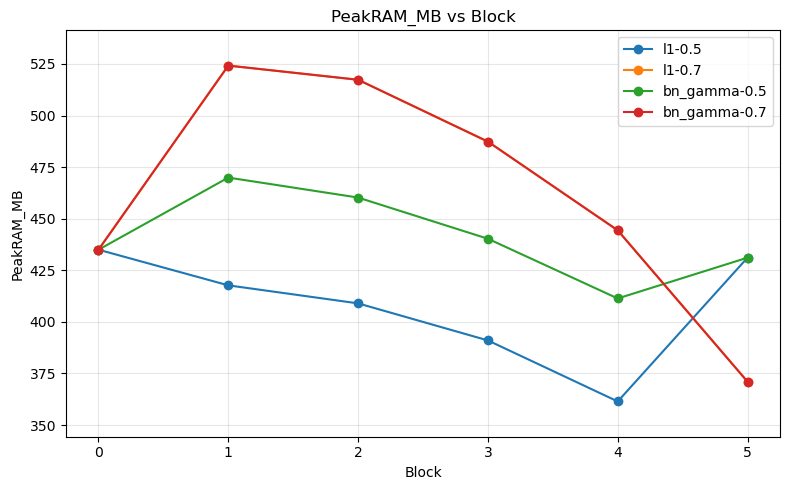

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/dermamnist_pgto_pruning_metrics.csv")

# Map Stage -> Block
def stage_to_block(stage):
    if stage == "baseline":
        return 0
    elif "layer1" in stage:
        return 1
    elif "layer2" in stage:
        return 2
    elif "layer3" in stage:
        return 3
    elif "layer4" in stage:
        return 4
    elif "finetune" in stage:
        return 5
    return None

df["Block"] = df["Stage"].apply(stage_to_block)

# Variants of interest
variants = [
    ("l1", 0.5),
    ("l1", 0.7),
    ("bn_gamma", 0.5),
    ("bn_gamma", 0.7),
]

# Metrics
metrics = ["Acc", "AUC", "Loss", "FLOPs_M_per_image", 
           "ModelSizeMB", "InferenceTime_per_batch32_s", "PeakRAM_MB"]

for metric in metrics:
    plt.figure(figsize=(8,5))

    for method, ratio in variants:
        # Get variant rows
        subset = df[(df["Variant"] == method) & (df["Ratio"] == ratio)]

        # Append baseline (Block 0) explicitly
        baseline = df[df["Stage"] == "baseline"].copy()
        baseline["Variant"] = method
        baseline["Ratio"] = ratio
        subset = pd.concat([baseline, subset]).sort_values("Block")

        # Plot
        plt.plot(
            subset["Block"], subset[metric],
            marker="o", label=f"{method}-{ratio}"
        )

    plt.xlabel("Block")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Block")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Ensure x-axis is discrete integers only
    plt.xticks(sorted(df["Block"].dropna().unique()))

    # Add padding to y-limits so curves don’t get cut off
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()


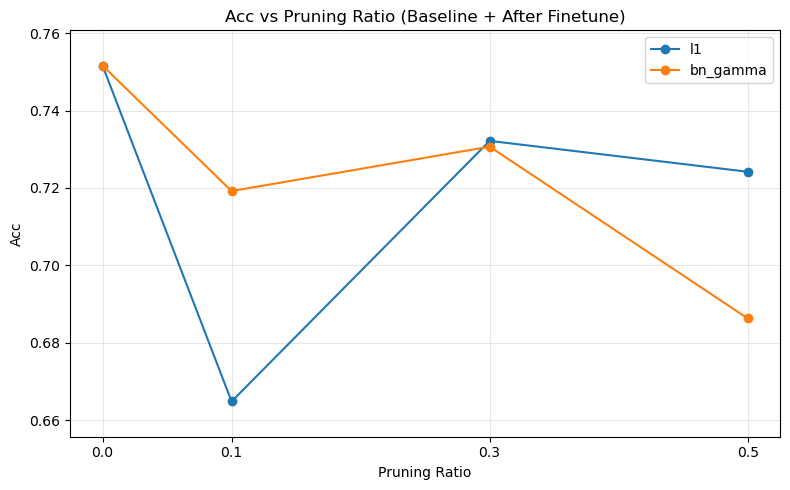

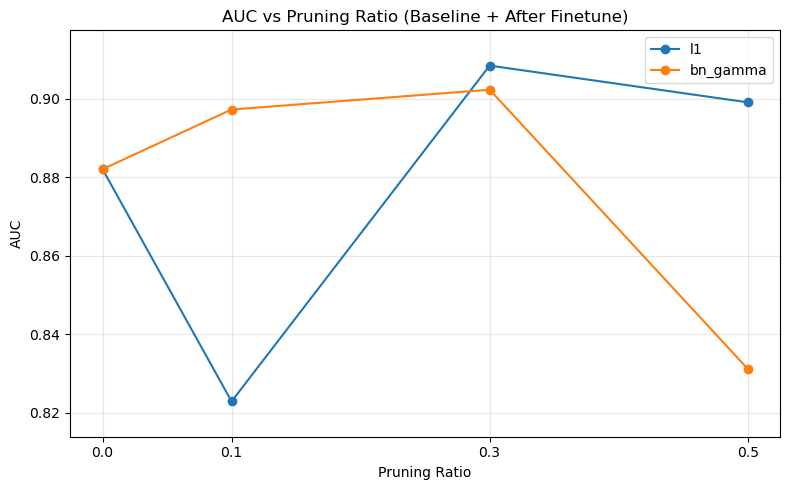

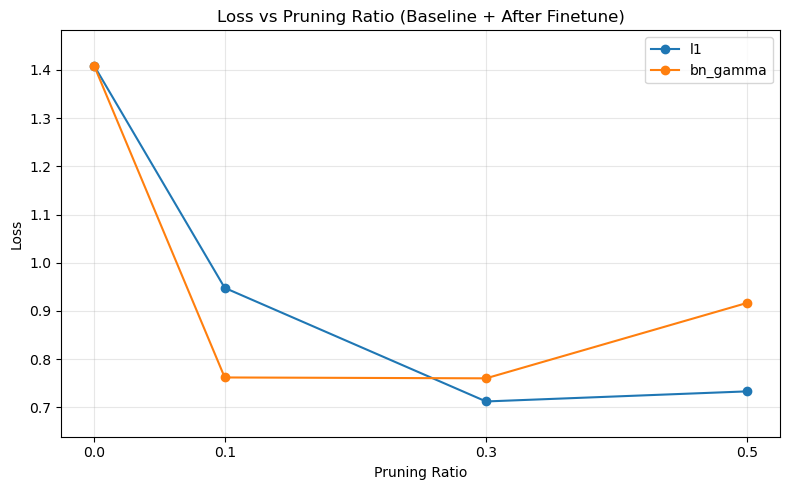

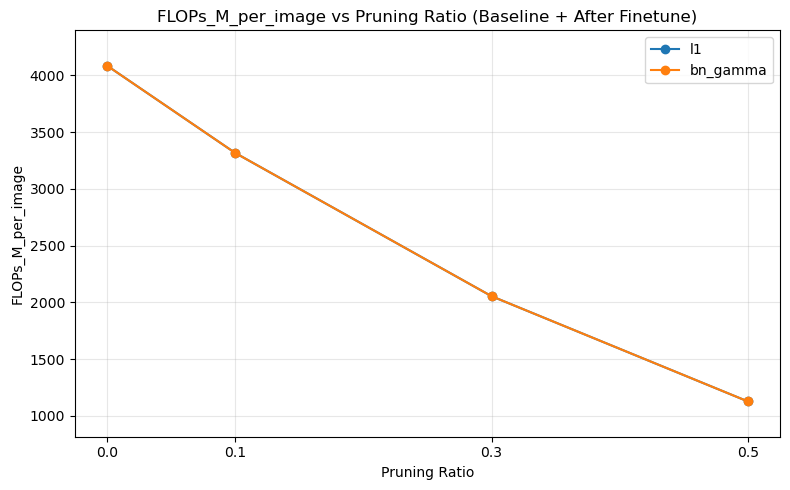

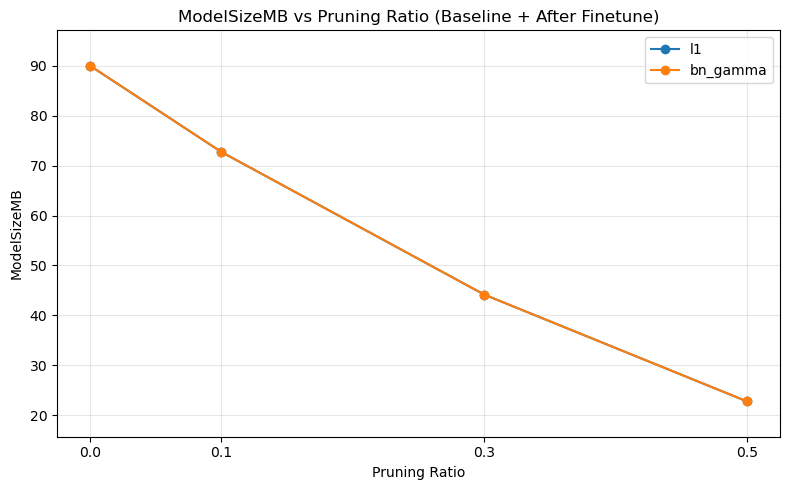

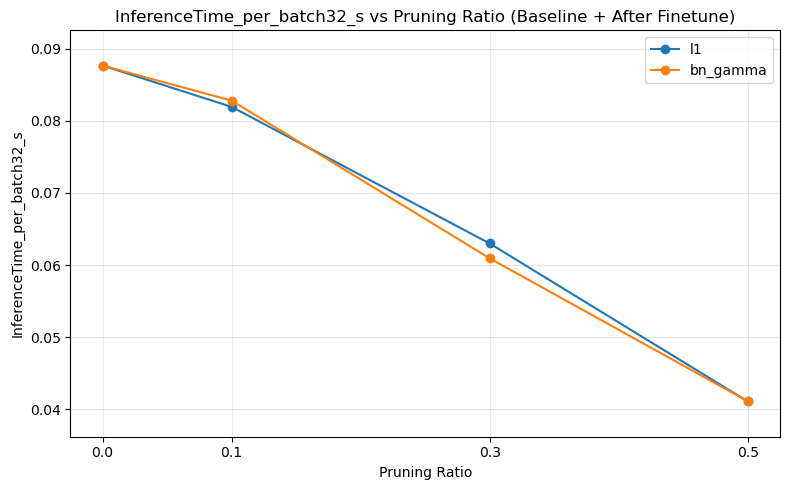

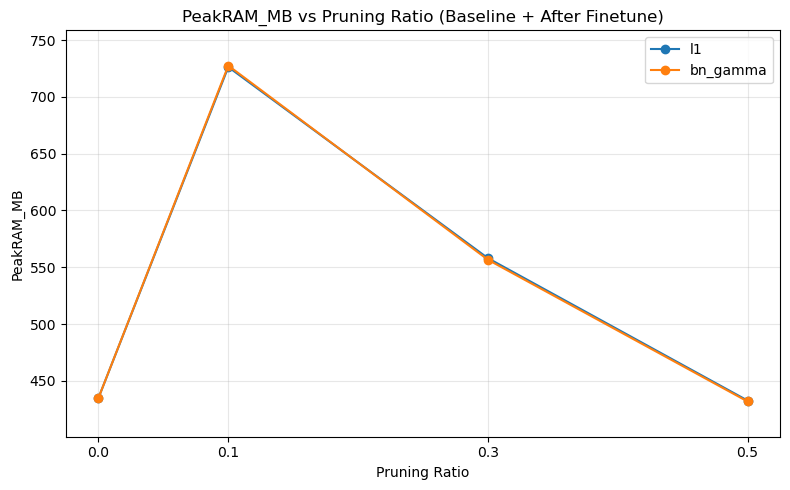

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/dermamnist_surgery_pruning_metrics.csv")

# Keep only baseline + after_finetune rows
df_baseline = df[df["Stage"] == "baseline"]
df_after = df[df["Stage"] == "after_finetune"]

# Metrics to plot
metrics = ["Acc", "AUC", "Loss", "FLOPs_M_per_image", 
           "ModelSizeMB", "InferenceTime_per_batch32_s", "PeakRAM_MB"]

# Variants of interest
variants = df_after["Variant"].unique()

for metric in metrics:
    plt.figure(figsize=(8,5))

    for variant in variants:
        # Get baseline row
        baseline_row = df_baseline.copy()
        baseline_row["Variant"] = variant  # assign to variant line

        # Get after_finetune rows for this variant
        after_rows = df_after[df_after["Variant"] == variant]

        # Combine baseline + after
        plot_data = pd.concat([baseline_row, after_rows]).sort_values("Ratio")

        plt.plot(
            plot_data["Ratio"], plot_data[metric],
            marker="o", label=variant
        )

    plt.xlabel("Pruning Ratio")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Pruning Ratio (Baseline + After Finetune)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # X-axis ticks = all ratios including 0 for baseline
    plt.xticks(sorted(plot_data["Ratio"].unique()))

    # Add y-axis padding
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()


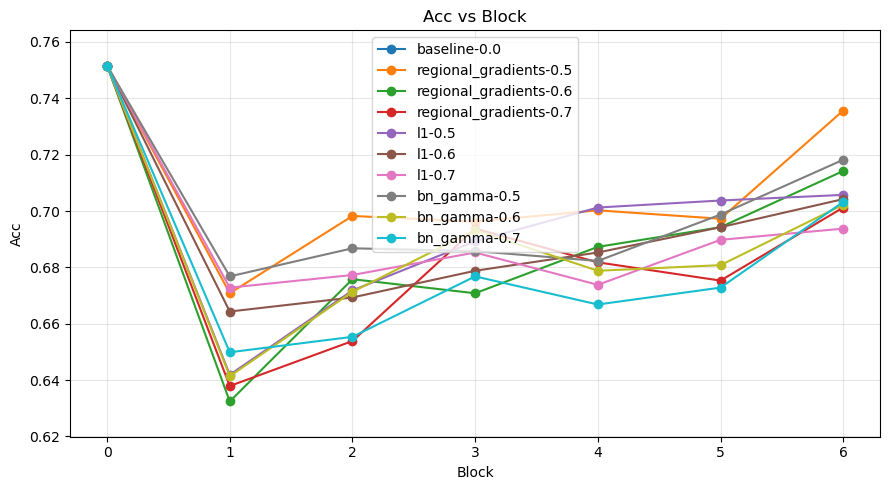

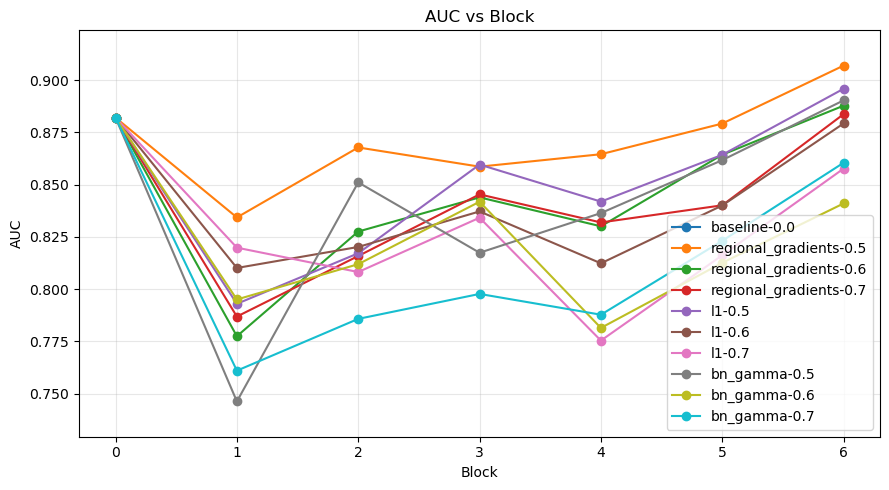

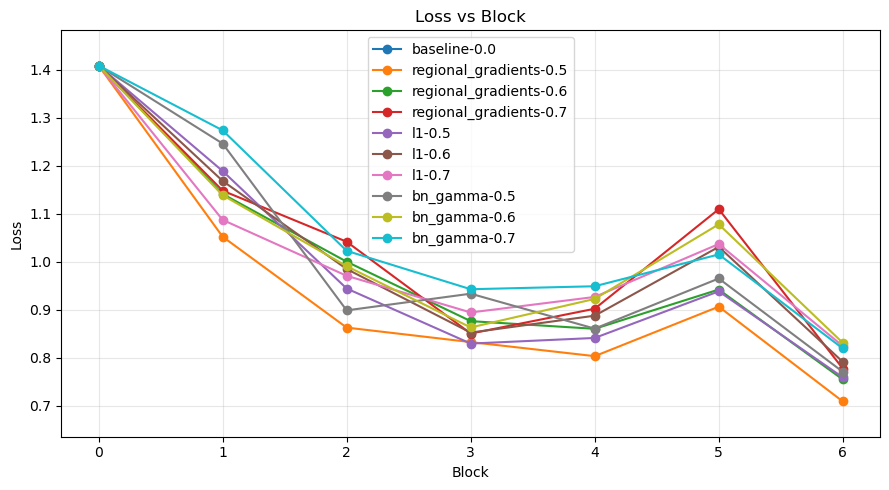

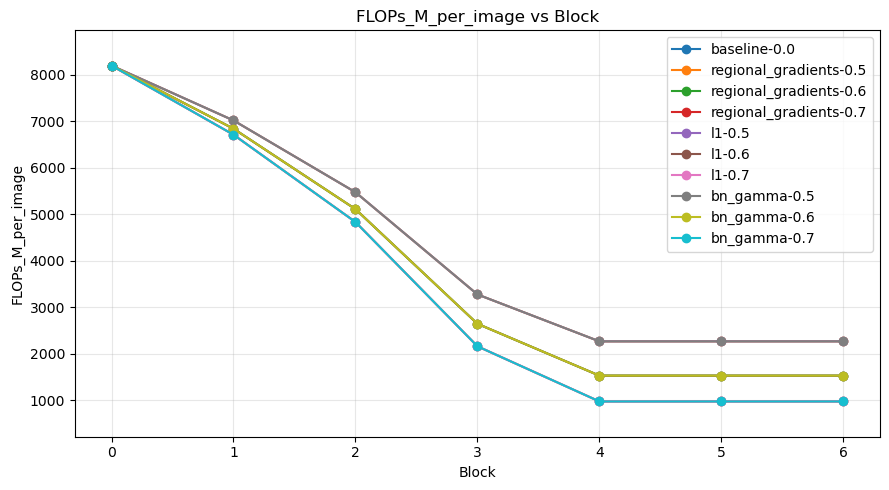

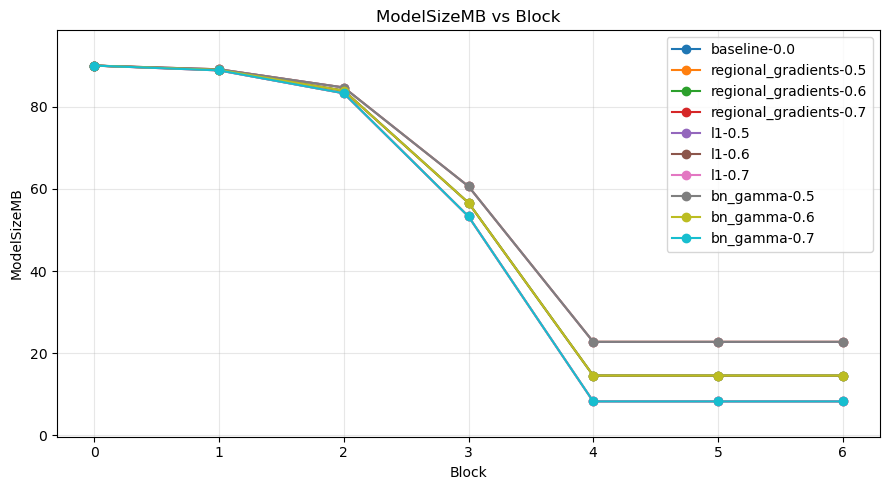

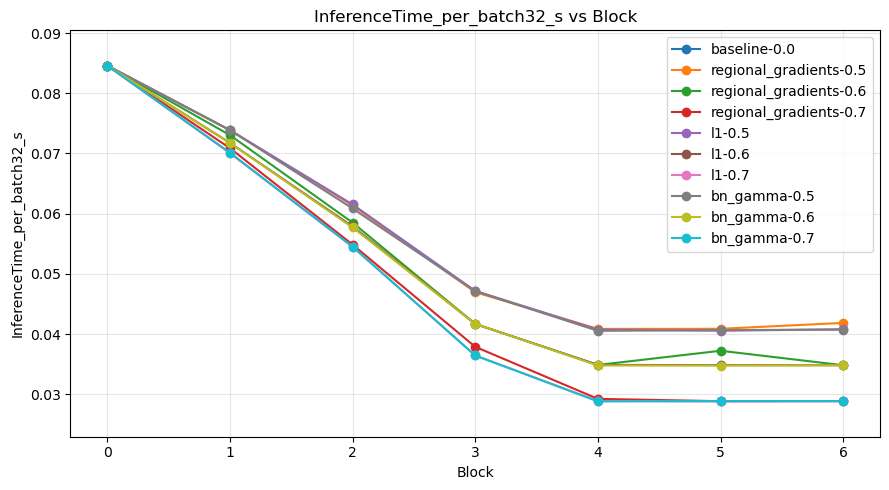

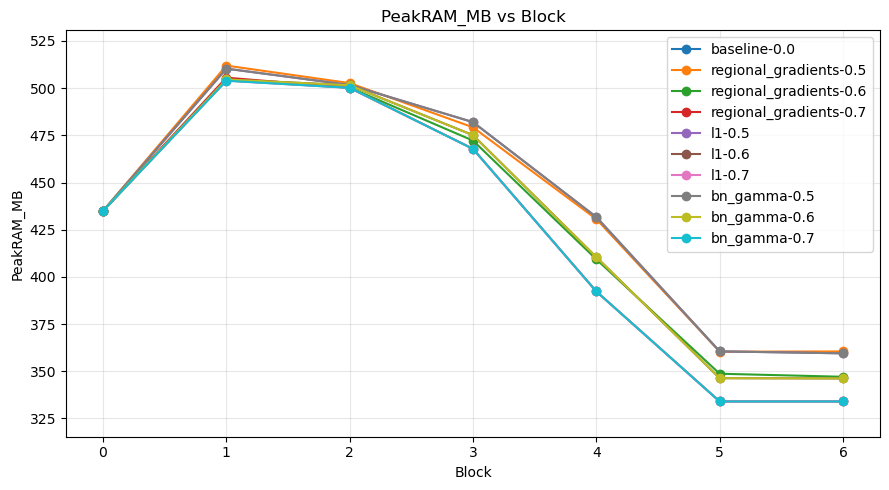

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/dermamnist_pgto_pruning_metrics_progressive_fixed.csv")

# Keep only desired stages
stages_keep = ["postcalib", "after_kd", "after_global_finetune", "baseline"]
df = df[df["Stage"].apply(lambda s: any(k in s for k in stages_keep))].copy()

# Map Stage -> Block index
def stage_to_block(stage: str):
    if stage == "baseline":
        return 0
    elif "layer1" in stage and "postcalib" in stage:
        return 1
    elif "layer2" in stage and "postcalib" in stage:
        return 2
    elif "layer3" in stage and "postcalib" in stage:
        return 3
    elif "layer4" in stage and "postcalib" in stage:
        return 4
    elif stage == "after_kd":
        return 5
    elif stage == "after_global_finetune":
        return 6
    return None

df["Block"] = df["Stage"].apply(stage_to_block)

# Use all unique (Variant, Ratio) pairs
variants = df[["Variant", "Ratio"]].drop_duplicates().values.tolist()

# Metrics to plot
metrics = [
    "Acc", "AUC", "Loss",
    "FLOPs_M_per_image", "ModelSizeMB",
    "InferenceTime_per_batch32_s", "PeakRAM_MB"
]

for metric in metrics:
    plt.figure(figsize=(9,5))

    for method, ratio in variants:
        # Get subset
        subset = df[(df["Variant"] == method) & (df["Ratio"] == ratio)].copy()

        # Add baseline explicitly for this variant/ratio
        baseline = df[df["Stage"] == "baseline"].copy()
        baseline["Variant"] = method
        baseline["Ratio"] = ratio
        subset = pd.concat([baseline, subset])

        # Order by Block
        subset = subset.sort_values("Block")

        # Plot
        plt.plot(
            subset["Block"], subset[metric],
            marker="o", label=f"{method}-{ratio}"
        )

    plt.xlabel("Block")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Block")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # X-axis ticks
    plt.xticks(sorted(df["Block"].dropna().unique()))

    # Add y padding
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()
